In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
#load signal, backgound data
vbf_events = pd.read_hdf("../MC_Prod_v12/vbf_events.hdf", "vbf")
ggf_events = pd.read_hdf("../MC_Prod_v12/ggF_events.hdf", "ggF")

In [3]:
vbf_events["class"] = 1
ggf_events["class"] = 0

In [4]:
data = pd.concat([vbf_events, ggf_events])
#print data.isnull().values.any()
#data.describe()
data = data.sample(frac=1).reset_index(drop=True) #shuffle the events
target = data["class"]
mass = data["m4l_fsr"]
weights = data["weight_couplings"]
del data["class"]
del data["m4l_fsr"]
del data["weight_couplings"]

In [5]:
data.head(5)

,dijet_invmass,dijet_deltaeta,eta_zepp_ZZ,min_dR_jZ,leading_jet_width,subleading_jet_width,jet_pt[0],jet_pt[1],"max(50,pt4ljj_unconstrained)"
0,356.650330,1.669236,0.888165,0.645989,0.066390,0.065942,160.391830,107.271393,81.475380
1,992.272217,6.654521,1.400082,2.667042,0.184306,0.061050,40.699841,31.229019,50.000000
2,1492.957275,5.679202,0.346004,1.832507,0.103212,0.072501,147.309769,52.006111,94.640076
3,362.621246,3.135902,0.380532,1.979456,0.038277,0.006525,106.111481,50.047699,50.000000
4,396.182526,2.721596,1.753255,1.458591,0.039014,0.057238,102.591476,90.672752,62.286587


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test, mass_train, mass_test, weights_train, weights_test = \
    train_test_split(data, target, mass, weights, train_size=0.75)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model
#from keras.optimizers import SGD

#@TODO: check other activations in Andreas, Gilles pivot
inputs = Input(shape=(X_train.shape[1],))
Dx = Dense(32, activation="relu")(inputs)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])
D.compile(loss="binary_crossentropy", optimizer="adam")

Using TensorFlow backend.
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
  if sys.path[0] == '':


In [8]:
#weights_train.isnull().any()

In [9]:
#weights_train *=1000000

In [10]:
#weights_train.describe()

In [11]:
#(weights_train ==0).any()

In [12]:
def get_class_weights(y, smooth_factor=0):
    """
    Returns the weights for each class based on the frequencies of the samples
    :param smooth_factor: factor that smooths extremely uneven weights
    :param y: list of true labels (the labels must be hashable)
    :return: dictionary with the weight for each class
    """
    from collections import Counter
    counter = Counter(y)

    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p

    majority = max(counter.values())

    return {cls: float(majority) / count for cls, count in counter.items()}

In [13]:
#D.fit(X_train, y_train, sample_weight=weights_train, nb_epoch=10) #nan loss
#D.fit(X_train, y_train, nb_epoch=10) #unweighted training !!! @TODO: weighted
D.fit(X_train, y_train, nb_epoch=10, class_weight=get_class_weights(y_train)) #unweighted training !!! @TODO: weighted

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
72115/72115 [==============================] - 5s - loss: 0.7617     
Epoch 2/10
72115/72115 [==============================] - 5s - loss: 0.7342     
Epoch 3/10
72115/72115 [==============================] - 5s - loss: 0.7292     
Epoch 4/10
72115/72115 [==============================] - 5s - loss: 0.7255     
Epoch 5/10
72115/72115 [==============================] - 5s - loss: 0.7235     
Epoch 6/10
72115/72115 [==============================] - 5s - loss: 0.7216     
Epoch 7/10
72115/72115 [==============================] - 5s - loss: 0.7199     
Epoch 8/10
72115/72115 [==============================] - 5s - loss: 0.7183     
Epoch 9/10
72115/72115 [==============================] - 5s - loss: 0.7176     
Epoch 10/10
72115/72115 [==============================] - 5s - loss: 0.7152     


In [14]:
get_class_weights(y_train)

{0: 6.374475917783005, 1: 1.0}

In [15]:
from sklearn.metrics import roc_auc_score
y_pred = D.predict(X_test)
y_pred = y_pred.ravel()
roc_auc_score(y_true=y_test, y_score=y_pred, sample_weight=weights_test)
#roc_auc_score(y_true=y_test, y_score=y_pred)

0.8909870274362397

In [16]:
y_pred

array([ 0.09728482,  0.07320319,  0.79686791, ...,  0.99798489,
        0.97133696,  0.96265858], dtype=float32)

In [18]:
mass.describe()

count    96154.000000
mean       409.301788
std        219.603745
min        220.001450
25%        269.205750
50%        338.666626
75%        467.695061
max       3806.846436
Name: m4l_fsr, dtype: float64

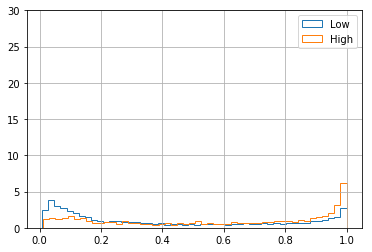

In [19]:
plt.hist(y_pred[mass_test<409], weights=weights_test[mass_test<409], bins=50, histtype="step", normed=1, label="Low")
plt.hist(y_pred[mass_test>=409], weights=weights_test[mass_test>=409], bins=50, histtype="step", normed=1, label="High")
#plt.hist(y_pred[mass_test<409], bins=50, histtype="step", normed=1, label="Low")
#plt.hist(y_pred[mass_test>=409], bins=50, histtype="step", normed=1, label="High")


plt.ylim(0, 30)
plt.legend()
plt.grid()
plt.show()

In [20]:
from scipy.stats import pearsonr
corr = pearsonr(mass_test, y_pred.ravel())
print "Unweighted correlation with mass is", corr

Unweighted correlation with mass is (0.1460292, 1.0901637514020769e-114)


In [ ]:
# now first put weights or itll just get all vbf correct

In [21]:
(y_pred>0.5).sum()/float(y_pred.shape[0])

0.72028786555181168

In [ ]:
# train with weights
# train with equalized weights
# shuffle dataset